This notebook will guide you through the main building blocks of our proposal:  
1. VQE state preparation + comparison with exact diagonalization results
2. Training the QAEAnsatz
3. Inference for the whole phase diagram

In [1]:
import time
import itertools
import numpy as np

import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator

from qiskit.opflow import CircuitSampler

from qiskit.ignis.mitigation.measurement import CompleteMeasFitter # you will need to pip install qiskit-ignis
from qiskit.ignis.mitigation.measurement import complete_meas_cal

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap("plasma") #'viridis'

from modules.utils import *

from qae import *

import datetime

In [2]:
print(qiskit.__version__, np.__version__)

0.17.4 1.20.1


In [3]:
IBMQ.load_account() # this then automatically loads your saved account
provider = IBMQ.get_provider(hub='ibm-q-research')

In [4]:
device = provider.backend.ibmq_rome # 6 bogota ; 4 rome

In [5]:
### Real device execution:
#backend = device 

### Simulation with noise profile from real device
backend = qiskit.providers.aer.AerSimulator.from_backend(device)

### Simulation without noise
#backend = qiskit.providers.aer.AerSimulator()

In [6]:
### Preliminaries
L = 5
num_trash = 2
anti = -1 # 1 for ferromagnetic Ising model, -1 for antiferromagnet

execute_VQE = False # whether or not you want to compute the VQE values; or load them

# dataset to be loaded (optimal VQE parameters)
# if execute_VQE is True this will overwrite the file
filename = f'data/noisy_rome_simu_VQE_maxiter-500_Ising_L5_anti_-1_10x10'

# Give a _unique_ name to this notebook execution, the results will be stored in the appropriate files with that name
name = "main" 

# VQE parameters
The first step of the algorithm is to prepare ground states for a given Hamiltonian. In this notebook we calculate the transverse-longidituidnal field Ising model (TLFI)
$$H=J\sum_{i=1}^{L} Z_{i} Z_{i+1}-g_{x} \sum_{i=1}^{L} X_{i}-g_{z} \sum_{i=1}^{L} Z_{i}$$
where $X_{i},Z_{i}$ are the Pauli matrices on site $i$, $J$ is the coupling strength, and $g_x, g_z$ are the transverse and longitudinal fields respectively. We fix $J=1$. In this case, the model has a quantum phase transition between an antiferromagnetic and paramagnetic phase, indicated by the order parameter $\hat{S}=\sum_{i=1^L} (-1)^i Z_i/L$ (staggered magnetization).  

The model Hamiltonian `Qmag(L,anti)` is imported from `modules/utils.py`. We also perform exact diagonalization for comparison.

Typically this part can take a while, both in noisy simulations or even more so on the real device, so we typically perform this part of the notebook separately over night. See `scripts/` for executable scipts on a cluster.

In [7]:
# May take some time. Ideally you would run this separately over night.
if execute_VQE:
    
    coupling_map = device.configuration().coupling_map
    noise_model = qiskit.providers.aer.noise.NoiseModel.from_backend(device)
    basis_gates = noise_model.basis_gates

    #aqua_globals.random_seed = seed
    qi = qiskit.utils.QuantumInstance(backend=backend, # , seed_simulator=seed, seed_transpiler=seed
                             coupling_map=coupling_map,
                             noise_model=noise_model, # comment out on real device execution
                             measurement_error_mitigation_cls= CompleteMeasFitter, 
                             cals_matrix_refresh_period=30  #How often to refresh the calibration matrix in measurement mitigation. in minutes
                                     )
    
    maxiter = 60 # per optimization; on the real device more than 60 is unrealistic due to large overhead
    logspace_size = 10
    gx_vals = np.logspace(-2,2,logspace_size)
    gz_vals = np.logspace(-2,2,logspace_size)
    
    rotation_blocks = "ry"
    entanglement_blocks = "cz"
    entanglement = "sca"
    reps = 1

    ansatz_config = dict(rotation_blocks = rotation_blocks, entanglement_blocks = entanglement_blocks, reps = reps, entanglement = entanglement)

    ansatz = qiskit.circuit.library.TwoLocal(L,rotation_blocks="ry", entanglement_blocks=entanglement_blocks, entanglement=entanglement, reps=reps)
    #ansatz.draw("mpl")
    ansatz = qiskit.transpile(ansatz, backend)
    #ansatz.draw("mpl")

    counts = []
    values = []

    optimizer = SPSA(maxiter=maxiter) #,learning_rate=0.3, perturbation=0.1; setting that speeds things up sometimes

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    opt_params = []
    gx_list = []
    gz_list = []
    countss, valuess = [], []
    Qmag, Qen, Smag, Sen = [],[],[],[]


    for j,gx in enumerate(gx_vals):
        for i,gz in enumerate(gz_vals):
            t0 = datetime.datetime.now()
            counts = []
            values = []

            vqe = VQE(ansatz=ansatz, optimizer=optimizer, callback=store_intermediate_result, quantum_instance=qi)

            H = QHIsing(L,anti,np.float32(gx),np.float32(gz))
            result = vqe.compute_minimum_eigenvalue(H, aux_operators = [QMag(L,anti)]) #ED with Qiskit VQE
            Qen.append(result.eigenvalue)
            Qmag.append(result.aux_operator_eigenvalues[0][0])
            countss.append(counts)
            valuess.append(values)

            ED_state, ED_E, ham = ising_groundstate(L, anti, np.float32(gx), np.float32(gz))
            Sen.append(ED_E)
            Smag.append(ED_state.T.conj()@Mag(L,anti)@ED_state)
            print(Qen[-1])
            print(Qmag[-1])

            print(f"ED energy: {Sen[-1]} ;; VQE energy: {Qen[-1]} ;; diff {Sen[-1] - Qen[-1]}")
            print(f"ED mag: {Smag[-1]} ;; VQE mag: {Qmag[-1]} ;; diff {Smag[-1] - Qmag[-1]}")


            gx_list.append(gx)
            gz_list.append(gz)
            opt_params.append(sort_params(result.optimal_parameters))
            print(f"{j+1} / {len(gx_vals)}, gx = {gx:.2f}, gz = {gz:.2f}, time : {(datetime.datetime.now() - t0)}")

            np.savez(filename, gx_list=gx_list, gz_list=gz_list, opt_params=opt_params, Qmag=Qmag, Qen=Qen, Sen=Sen, Smag=Smag, ansatz_config=ansatz_config)

In [8]:
if not execute_VQE:
    VQE_params = np.load(filename + ".npz", allow_pickle=True)
    
    ansatz_config = VQE_params["ansatz_config"].item()
    
    gx_list = VQE_params['gx_list']
    gz_list = VQE_params['gz_list']
    opt_params = VQE_params['opt_params']

    gx_vals = np.unique(gx_list)
    gz_vals = np.unique(gz_list)

    mag = QMag(L,anti) #magnetization operator (Qiskit)
    Smag = Mag(L,anti) #magnetization operator (numpy)
    # the ~ is the adjoint, but also it turns the is_measurement attribute to True
    ~StateFn(mag)
    # state is technically a circuit, that prepares the ground state via VQE circuit
    #state.draw() # uncomment to see, but is very long

    Qen= VQE_params["Qen"]; Sen= VQE_params["Sen"] #energies
    Qmags=VQE_params["Qmag"]; Smags=VQE_params["Smag"] #magnetizations

The following Ansatz was chosen after some empirical testing, finding a trade-off between expressibility and noise robustness. We saw that too many entangling gates diminished the results, which is why we reduced the number of layers. Further, since long-range entangling gates are transpiled to many consecutive local entangling gates on a linear real device like `ibmq_rome` or `ibmq_bogota`, we also tried to avoid them as best as possible.

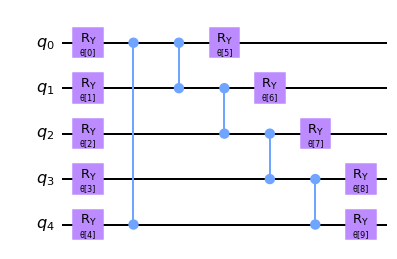

In [9]:
ansatz = qiskit.circuit.library.TwoLocal(L,**ansatz_config)
ansatz.draw("mpl")

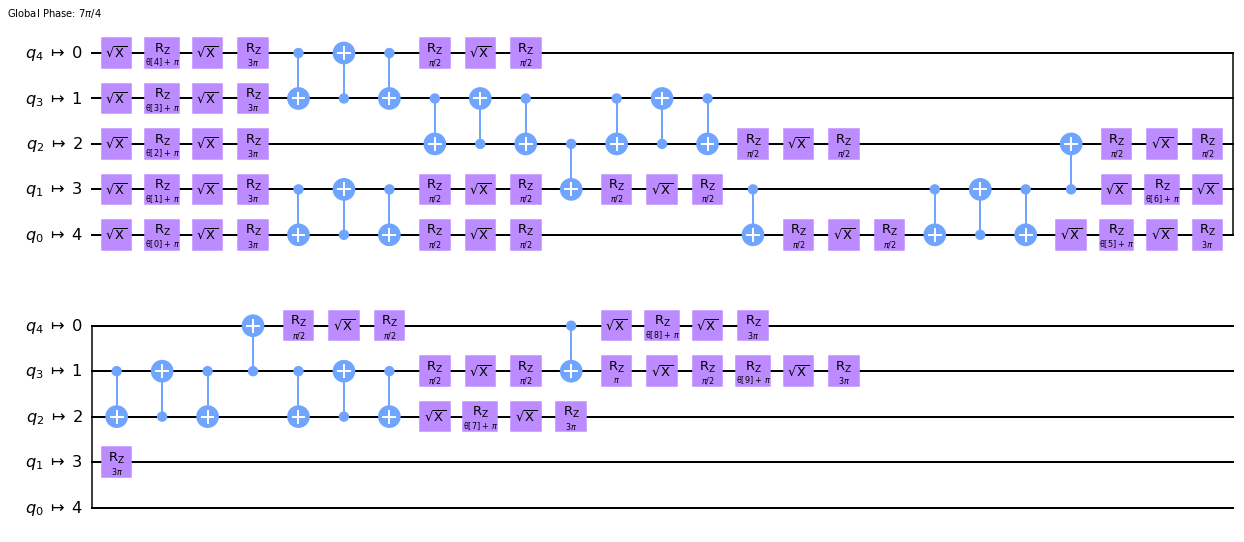

In [10]:
# what the device would actually execute:
ansatz = qiskit.transpile(ansatz, backend)
ansatz.draw("mpl")

## ED comparison

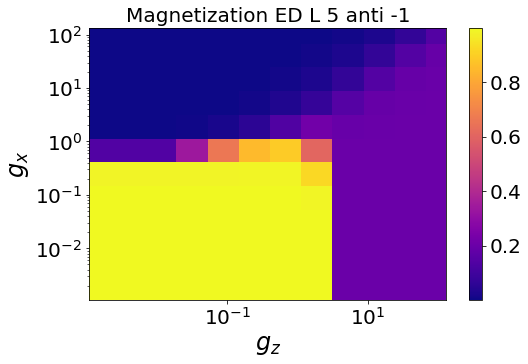

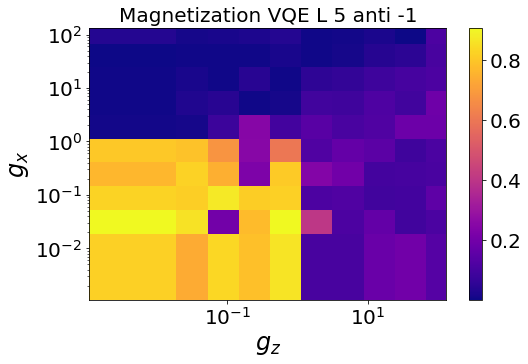

In [11]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Smags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap, shading="auto")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization ED L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(gz_vals, gx_vals, abs(Qmags).reshape(len(gz_vals),len(gx_vals)), cmap=cmap, shading="auto")
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

<ipython-input-12-a446ca9f8ee0>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(gz_vals, gx_vals, (Sshaped - Qshaped)/Sshaped , cmap=cmap)


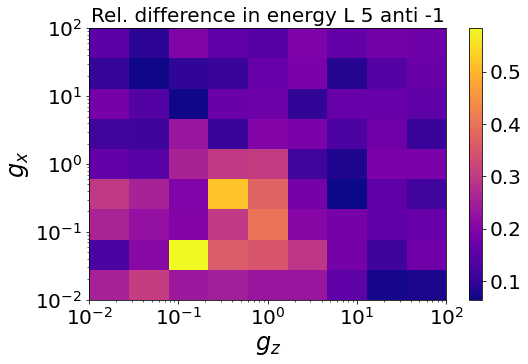

In [12]:
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
Sshaped = np.float64(Sen.reshape(len(gz_vals),len(gx_vals)))
Qshaped = np.float64(Qen.reshape(len(gz_vals),len(gx_vals)))
im = ax.pcolormesh(gz_vals, gx_vals, (Sshaped - Qshaped)/Sshaped , cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Rel. difference in energy L %.0f anti %.0f" %(L, anti),fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

# Quantum Anomaly Detection
Now that we have our ground states prepared, we can use them as the input to the Quantum Anomaly Syndrome. This is composed of the following circuit. The goal is to disentangle the trash qubits, in this case with indices `trash_qubits_idxs = [1,2]`, from the rest of the system. Again, we try to be minimalistic with the entangling gates while maintaining high expressibility for the task. We therefore put the trash qubits at the center of the physical device (linear chain) and connect only the trash qubits among themselves and the remaining qubits.

The Ansatz circuit for our anomaly syndrome is based on a quantum autoencoder, which we implemented in `qae.py` with the classes `QAEAnsatz()` and `QAE`.

In [15]:
# Using our QAEAnsatz class (described in qae.py)
circ = QAEAnsatz(num_qubits = L, num_trash_qubits= num_trash, trash_qubits_idxs = [1,2], measure_trash=True)

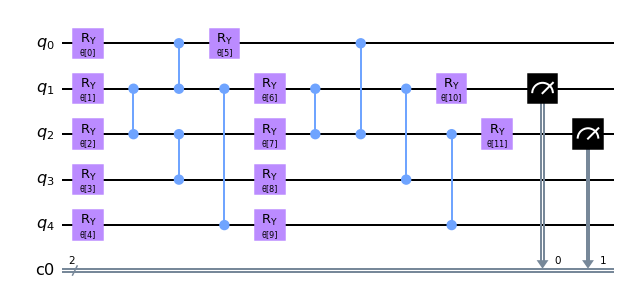

In [16]:
circ.draw("mpl")

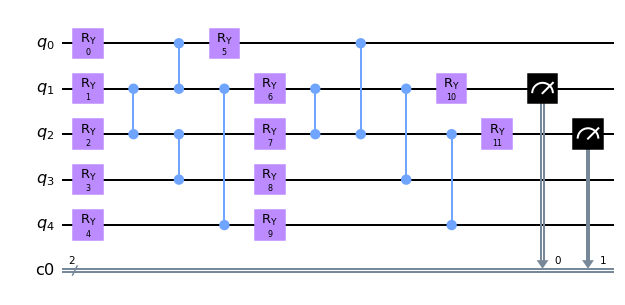

In [17]:
# an example with assigned parameters
circ = circ.assign_parameters(np.arange(L*2+2))
circ.draw("mpl")

Initialize state with VQE circuit _or_ state vector

In [17]:
def prepare_circuit(thetas, L=6, num_trash=2, init_state=None, measurement=True, vqe=True):
    QAE_circ = QAEAnsatz(num_qubits = L, num_trash_qubits= num_trash, measure_trash=measurement).assign_parameters(thetas)
    if vqe:
        VQE_circ = ansatz.assign_parameters(init_state)
        fullcirc = VQE_circ + QAE_circ
    else:
        fullcirc = QAE_circ.initialize(init_state, qreg)
    return fullcirc

<ipython-input-17-0802c256ac19>:5: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  fullcirc = VQE_circ + QAE_circ
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


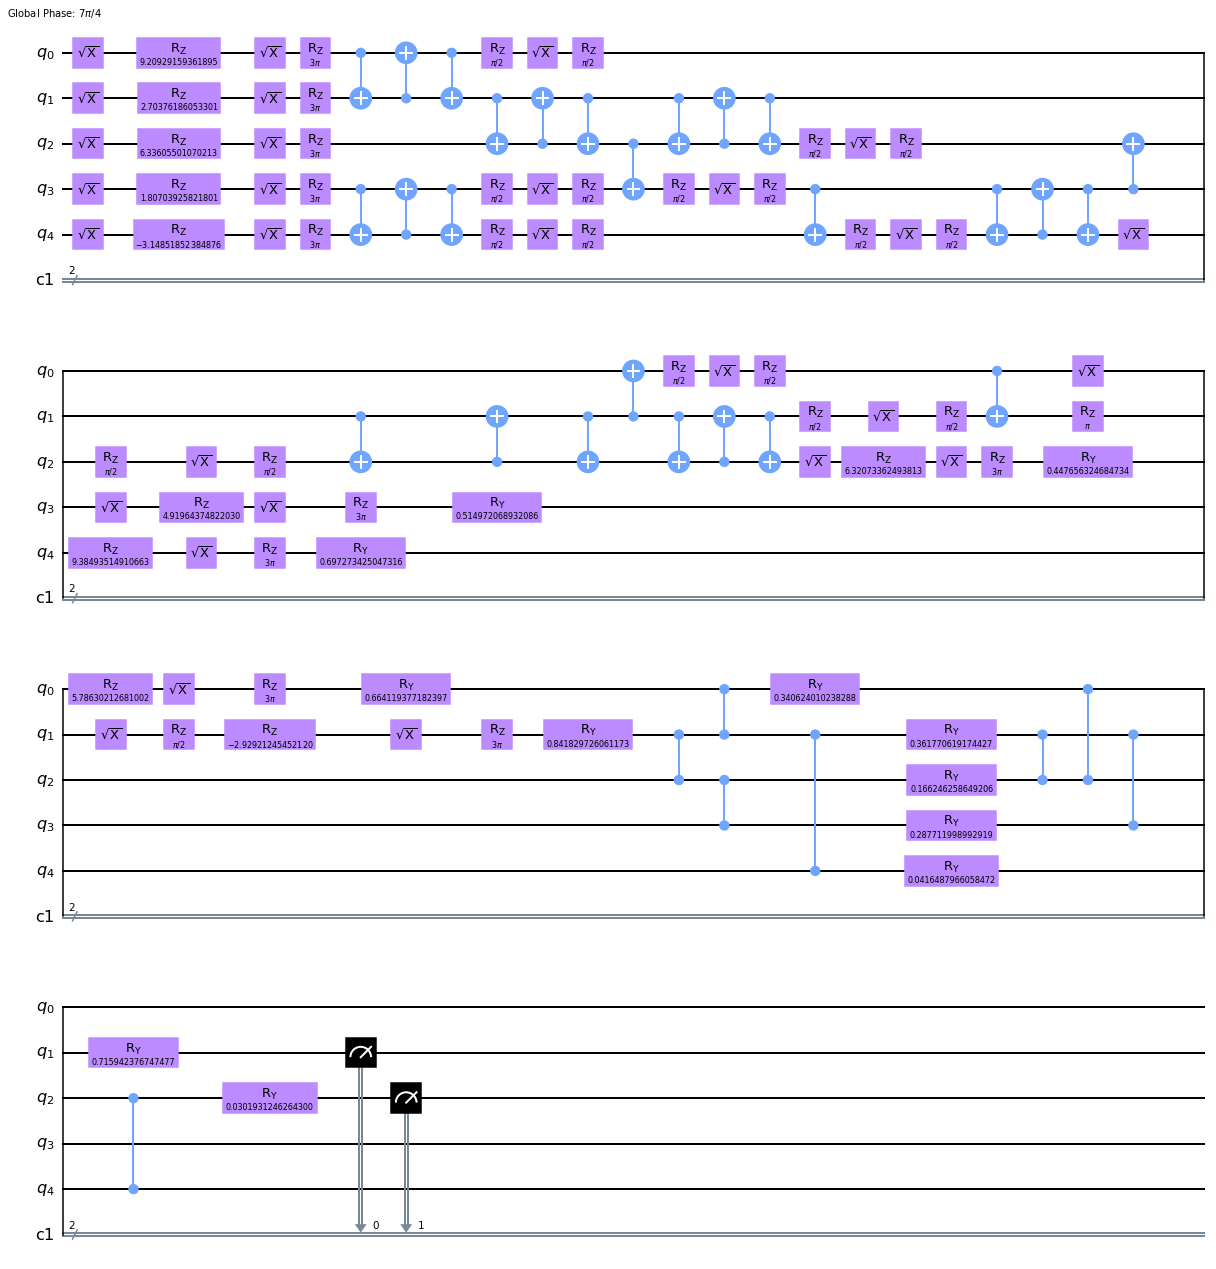

In [18]:
# example of the full circuit with random parameters assigned
fullcirc = prepare_circuit(np.random.rand(L*2+2),L,num_trash, vqe=True, init_state=opt_params[0])
fullcirc.draw("mpl")


Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [19]:
### Circuit calibration (for measurement error mitigation in noisy simulations and real device execution)
def calibrate_circuit(L, nums_trash=[1,2],shots=1000):
    # outputs a CompleteMeasFitter object for alter use
    num_trash = len(nums_trash)
    qreg = QuantumRegister(L, 'q')
    # obtain calibration matrix
    qubit_list = [i for i in nums_trash] # only need to calibrate the trash qubits
    circlabel = f'mcal_{datetime.datetime.now()}'
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qreg, circlabel=circlabel)
    cal_job = backend.run(meas_calibs, shots=shots) #, noise_model=noise_model)
    cal_results = cal_job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel=circlabel)
    print(circlabel, meas_fitter.cal_matrix)
    return meas_fitter

In [20]:
### Execute circuit
def run_circuit(thetas, L, num_trash, init_state, vqe=True, shots=100, meas_fitter = None):
    circ = prepare_circuit(thetas, L, num_trash, init_state, vqe=vqe)
    tcirc = qiskit.transpile(circ, backend)
    # Execute the circuit 
    job_sim = backend.run(tcirc, shots=shots) # , seed_simulator=123, seed_transpiler=234 fix seed to make it reproducible
    result = job_sim.result()
    # Results without mitigation
    counts = result.get_counts()
    if meas_fitter != None:
        # Get the filter object
        meas_filter = meas_fitter.filter

        # Results with mitigation
        mitigated_results = meas_filter.apply(result)
        counts = mitigated_results.get_counts(0)
    return counts

In [21]:
phis = opt_params # the parameters for the VQE initialization

In [22]:
### Optimize circuit
def cost_function_single(thetas, L, num_trash, p, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    if vqe:
        init_state = phis[p]
    else:
        J, gx, gz = p
        init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, L, num_trash, init_state, vqe=vqe, shots=shots, meas_fitter=meas_fitter)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

def cost_function(thetas, L, num_trash, ising_params, shots=1000, vqe=True, param_encoding=False, x=0, meas_fitter=None):
    """ Optimizes circuit """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        if param_encoding: 
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, x[i], meas_fitter=meas_fitter)
        else:
            cost += cost_function_single(thetas, L, num_trash, p, shots, vqe, param_encoding, meas_fitter=meas_fitter)
    return cost/n_samples

def optimize(ising_params, L=6, num_trash=2, thetas=None, shots=1000, max_iter=400, vqe=True, param_encoding=False, x=0, pick_optimizer = None,
            meas_fitter=None):
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
        
    print("Initial cost: {:.3f}".format(cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x)))
    
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        # counts.append(eval_count)
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    if pick_optimizer == "cobyla":
        optimizer = COBYLA(maxiter=max_iter, tol=0.0001)
    if pick_optimizer == "adam" or pick_optimizer == "ADAM":
        optimizer = qiskit.algorithms.optimizers.ADAM(maxiter=max_iter)
    # optimizer = L_BFGS_B(maxfun=300, maxiter=max_iter)#, factr=10, iprint=- 1, epsilon=1e-08)
    if pick_optimizer == "spsa" or pick_optimizer == None:
        optimizer = SPSA(maxiter=max_iter,
                         #blocking=True,
                         callback=store_intermediate_result,
                         learning_rate=0.3,
                         perturbation=0.1
                         ) # recommended from qiskit (first iteraction takes quite long)
                           # to reduce time figure out optimal learning rate and perturbation in advance

    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, L, num_trash, ising_params, shots, vqe, param_encoding, x, meas_fitter=meas_fitter)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted



In [23]:
def run_inference(thetas, shots=1000, L=5, meas_fitter=None):
    points = 50
    J = -1.0
    x,y = np.meshgrid(gx_vals, gz_vals)
    cost = np.zeros((len(gx_vals) * len(gz_vals)))
    Smags = np.zeros((len(gx_vals) * len(gz_vals)))
    shots = 1000
    for i,p in enumerate(list(zip(gxs, gzs))):
        t0 = datetime.datetime.now()
        cost[i] = cost_function_single(thetas, L, num_trash, i, shots=shots, meas_fitter=meas_fitter)
        if not i%verbose:
            print(f"{i+1} / {len(opt_params)}, gx = {gx:.2f}, gz = {gz:.2f}, time : {verbose*(datetime.datetime.now() - t0)}")

    cost = cost.reshape((len(gx_vals), len(gz_vals)))
    return cost

cmap = plt.get_cmap("plasma")
def plot_result(cost, params):
    fig,axs = plt.subplots(ncols=2,figsize=(15,5))
    nbins=100
    ax = axs[0]
    im = ax.pcolormesh(x, y, cost, cmap=cmap, shading="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"Loss",fontsize=20)
    ax.set_xlabel(r"$g_z$",fontsize=24)
    ax.set_ylabel(r"$g_x$",fontsize=24)
    ax.tick_params(labelsize=20)
    for p in params:
        gz = gz_list[p]
        gx = gx_list[p]
        ax.plot(gz,gx,"o",label="training",color="cyan")
    
    ax = axs[1]
    im = ax.pcolormesh(gz_vals, gx_vals, Qmags.real.reshape(len(gz_vals),len(gx_vals)), cmap=cmap, shading="auto")
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.tick_params(labelsize=20)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title("Magnetization VQE L %.0f anti %.0f" %(L, anti),fontsize=20)
    ax.set_xlabel(r"$g_z$",fontsize=24)
    ax.set_ylabel(r"$g_x$",fontsize=24)
    ax.tick_params(labelsize=20)

## Error mitigation
We perform measurement error mitigation by calibrating the device for predefined states and their expected vs. measured clicks. The calibration matrix can be computed via `calibrate_circuit()`. We then perform the opitmization of the circuit with and without measurement error mitigation and compare the results.

In [24]:
meas_fitter = calibrate_circuit(L, nums_trash=[1,2])

mcal_2021-06-05 17:56:00.212228 [[0.967 0.039 0.034 0.   ]
 [0.017 0.947 0.    0.033]
 [0.015 0.    0.944 0.036]
 [0.001 0.014 0.022 0.931]]


Initial cost: 0.693
Time: 57.71600 sec
(array([ 3.77359581,  3.05683067,  0.34147804,  0.42026656,  5.51294368,
        0.17702344,  6.44611065,  6.00344303,  4.3687852 ,  3.78006363,
        3.0908591 , -0.01143369]), 0.3334457185703915, 360)


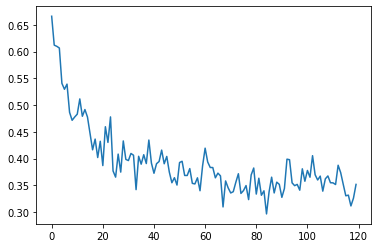

In [25]:
# Training
phys_params = [0] # train on antiferromagnetic state
thetas_opt_mitigated, loss, accepted = optimize(phys_params, max_iter=120, L=5,meas_fitter=meas_fitter) #, pick_optimizer="adam")
plt.plot(loss)

Initial cost: 1.217
Time: 54.52249 sec
(array([ 0.63471543, -0.04898115,  0.13829419,  5.55526607,  4.01259546,
        0.65946517,  0.20278175,  6.43869195,  0.8057128 ,  7.11513677,
       -0.08205213,  0.06751919]), 0.295, 360)


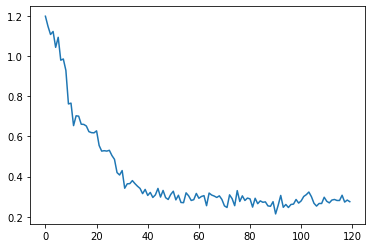

In [26]:
# Training
phys_params = [0]
thetas_opt_raw, loss, accepted = optimize(phys_params, max_iter=120, L=5,meas_fitter=None) #, pick_optimizer="adam")
plt.plot(loss)

In [27]:
#phi = opt_params[0]
raw_counts = run_circuit(thetas_opt_raw, L, num_trash, phis[0], meas_fitter=None)
mitigated_counts = run_circuit(thetas_opt_mitigated, L, num_trash, phis[0], meas_fitter=meas_fitter)

In [28]:
np.savez("data/" + name + "raw-vs-mitigated-counts",raw_counts=raw_counts, mitigated_counts = mitigated_counts)

The goal of the optimization is to have a product state $|00\rangle$ in the trash qubits. We therefore expect to measure mostly clicks in the $00$ component (this does NOT mean we have $|00\rangle$ state). We see that with measurement error mitigation we can improve our results a bit so we keep it for the folloing calculations.

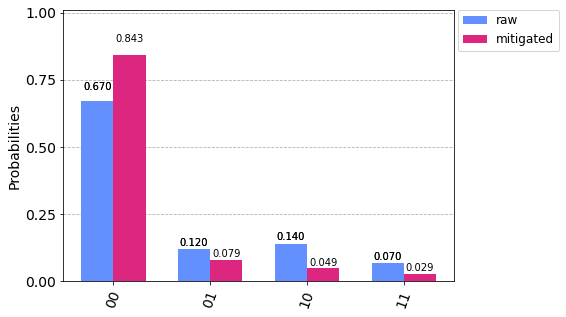

In [29]:
from qiskit.tools.visualization import *
temp = np.load("data/" + name + "raw-vs-mitigated-counts.npz",allow_pickle=True)
plot_histogram([temp["raw_counts"].item(), temp["mitigated_counts"].item()], legend=['raw', 'mitigated'])

# Optimization and inference
We now perform the full algorithm. The circuit is trained on one ground state, given by `phys_params`, which is a list of indices to pick from the prepared VQE parameters. After optimizing the circuit to yield $00$ cost in the trash qubits, we perform inference on all states we prepared via VQE and compare their cost. From this we can deduce the phase diagram.

Initial cost: 1.140
Time: 28.62011 sec
(array([3.2479617 , 4.9874594 , 3.94161883, 2.65900339, 0.33787049,
       2.93035159, 1.87392164, 4.68473068, 0.19306756, 0.13550995,
       2.51099489, 4.51515248]), 0.4167375935960797, 180)


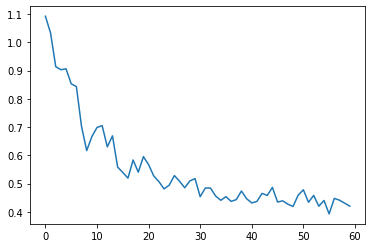

In [31]:
# Training
phys_params = [0]
thetas_opt, loss, accepted = optimize(phys_params, max_iter=60, L=5, meas_fitter=meas_fitter) #, pick_optimizer="adam")
plt.plot(loss)

In [32]:
# Inference; note that on the real device each inference points takes about ~30 seconds
x,y = np.meshgrid(gx_vals, gz_vals)
cost = np.zeros((len(gx_vals) * len(gz_vals)))
shots = 1000
for i,p in enumerate(list(zip(gx_list, gz_list))):
    t0 = datetime.datetime.now()
    cost[i] = cost_function_single(thetas_opt, L, num_trash, i, shots=shots, meas_fitter=meas_fitter) # np.random.uniform(0, 2*np.pi, 2*L+2) random parameters to check if training "does" something - result was: with random paremters just get noise, so yes, it "does" something
    print(f"{i} / {len(gx_list)} - execution time {datetime.datetime.now()-t0}")
cost = cost.reshape((len(gx_vals), len(gz_vals)))

0 / 100 - execution time 0:00:00.168626
1 / 100 - execution time 0:00:00.147968
2 / 100 - execution time 0:00:00.152275
3 / 100 - execution time 0:00:00.294944
4 / 100 - execution time 0:00:00.151128
5 / 100 - execution time 0:00:00.160198
6 / 100 - execution time 0:00:00.151200
7 / 100 - execution time 0:00:00.163891
8 / 100 - execution time 0:00:00.146231
9 / 100 - execution time 0:00:00.156398
10 / 100 - execution time 0:00:00.158075
11 / 100 - execution time 0:00:00.159400
12 / 100 - execution time 0:00:00.149901
13 / 100 - execution time 0:00:00.153063
14 / 100 - execution time 0:00:00.146797
15 / 100 - execution time 0:00:00.158929
16 / 100 - execution time 0:00:00.151651
17 / 100 - execution time 0:00:00.163681
18 / 100 - execution time 0:00:00.148009
19 / 100 - execution time 0:00:00.157937
20 / 100 - execution time 0:00:00.150270
21 / 100 - execution time 0:00:00.159360
22 / 100 - execution time 0:00:00.166637
23 / 100 - execution time 0:00:00.160574
24 / 100 - execution time 

In [33]:
np.save("data/" + name + "_thetas-loss-cost_run1",cost)

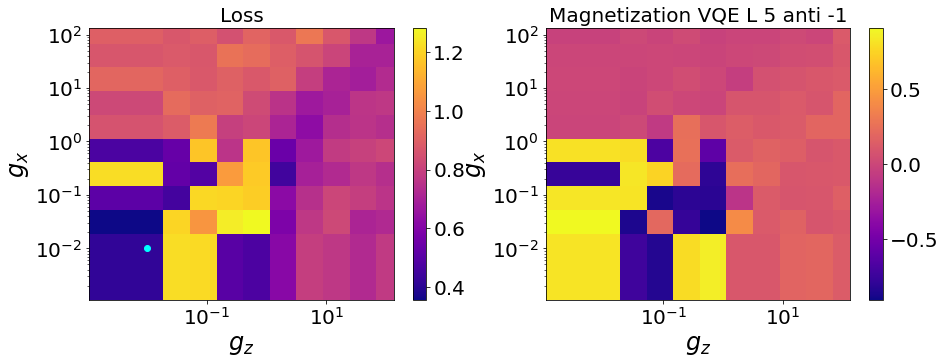

In [34]:
plot_result(np.load("data/" + name + "_thetas-loss-cost_run1.npy"),phys_params)